In [1]:
#imports
import numpy as np
import pandas as pd
from torch.distributions.beta import Beta
import os
import scipy
import seaborn as sns
import warnings
import scanpy as sc
import numpy.matlib
import numpy as np 
import torch
import json
#from pyvis.network import Network
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as ds
from torch.autograd import Variable
from torch import optim
from sklearn.decomposition import NMF
from opt_einsum import contract 
#from util import s_term_normal, s_term_bernoulli
from torch.distributions.normal import Normal
from torch.distributions.log_normal import LogNormal
from torch.distributions.dirichlet import Dirichlet
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
import matplotlib

#spade imports
from pyspade_global import *
from util import *
import argparse


In [2]:
%matplotlib inline
sns.set_style('white')
sns.set_style("ticks", {"xtick.direction": 'in', "ytick.direction": 'in'})

matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [3]:
#create train and test data for the paper results

In [4]:
FILE = "data/BRCA-X-TIL-X-Bassez_2021-X-cohort1_2_raw_filtered_clustered_drops_annotated_nodrops_log1p_clustered_leukocytes_scran_annotated_clustered_imputed_hvgenes_andmarker_15000_clustered_imputed_v2_210501_annotated_211208.h5ad"
adata = sc.read_h5ad(FILE)

## load data

In [5]:
def process_Bassez_r(hv = 3000,pseudocount = 3.0):
    FILE = "data/BRCA-X-TIL-X-Bassez_2021-X-cohort1_2_raw_filtered_clustered_drops_annotated_nodrops_log1p_clustered_leukocytes_scran_annotated_clustered_imputed_hvgenes_andmarker_15000_clustered_imputed_v2_210501_annotated_211208.h5ad"
    adata = sc.read_h5ad(FILE)
    f1 = pd.read_csv("data/SPADE_cells_x_genesets_celltype-specific_modified_for_SPADE.csv")
    f2 = pd.read_csv("data/SPADE_cells_x_genesets_general.csv")
    f3 = pd.read_csv("data/SPADE_genes_x_genesets.csv")
    

    adata.var['ighm'] = adata.var_names.str.startswith('IGHM')
    adata.var['iglc'] = adata.var_names.str.startswith('IGLC')
    adata.var['ighg'] = adata.var_names.str.startswith('IGHG')
    adata.var['igha'] = adata.var_names.str.startswith('IGHA')



    adata.var['ighv'] = adata.var_names.str.startswith('IGHV')
    adata.var['iglv'] = adata.var_names.str.startswith('IGLV')
    adata.var['igkv'] = adata.var_names.str.startswith('IGKV')
    adata.var['trbv'] = adata.var_names.str.startswith('TRBV')
    adata.var['trav'] = adata.var_names.str.startswith('TRAV')
    adata.var['trgv'] = adata.var_names.str.startswith('TRGV')
    adata.var['trdv'] = adata.var_names.str.startswith('TRDV')

    adata.var['hb'] = adata.var_names.str.startswith('HB')

    adata = adata[:,~(adata.var['hb']|adata.var['ighm']|adata.var['iglc']|adata.var['ighg']|adata.var['igha']|adata.var['ighv']|adata.var['trgv']|adata.var['trdv']|adata.var['iglv']|adata.var['igkv']|adata.var['trav']|adata.var['trbv'])]
    sc.pp.highly_variable_genes(adata, n_top_genes = hv, flavor = "cell_ranger")
    
    #remove genes that don't appear in the data
    gene_lst = adata.var.index
    remove = []
    genes = []
    for gene_name in f3["g.name"]:
        if gene_name not in gene_lst:
            f3 = f3[f3["g.name"] != gene_name]

    full_genes = list(f3["g.name"])
    bools = []
    for name in adata.var.index:
        if name in full_genes:
            bools.append(True)
        else:
            bools.append(False)
    bools = np.array(bools)
    adata2 = adata[:,adata.var.highly_variable.values|bools]
    #do we exponentiate X?
    #X = np.exp(np.array(adata2.X))
    X = np.array(adata2.X)
    X = X + pseudocount
    vocab = adata2.var_names
    word2id = dict((v, idx) for idx, v in enumerate(vocab))
    id2word = dict((idx, v) for idx, v in enumerate(vocab))
    labels = np.array(adata2.obs.annotation_SPADE_1)

    adict = OrderedDict()
    weights = OrderedDict()
    gs_dict = OrderedDict()
    gene_names_dict = OrderedDict()
    gs_names = OrderedDict()
    gs_dict_test = OrderedDict()
    gene_names_dict_test = OrderedDict()


    lst = []
    lst_test = []
    names = []
    for gs in f2["gs.name"].unique():
        gene_set = list(set(f3[f3["gs.name"] == gs]["g.name"]))
        if len(gene_set) > 0:
            rand_perm = np.random.permutation(len(gene_set))
            train_idx = rand_perm[:int(0.6*len(gene_set))]
            test_idx = rand_perm[int(0.6*len(gene_set)):]
            gene_set_train = list(np.array(gene_set)[train_idx])
            lst.append(gene_set_train)
            gene_set_test = list(np.array(gene_set)[test_idx])
            lst_test.append(gene_set_test)
            names.append(gs)
    adict["global"] = am(lst,word2id)
    weights["global"] = am_weighted(lst,word2id)
    gs_dict["global"] = [[word2id[i] for i in j] for j in lst]
    gs_dict_test["global"] = [[word2id[i] for i in j] for j in lst_test]
    gene_names_dict["global"] = {names[i]:lst[i] for i in range(len(lst))}
    gene_names_dict_test["global"] = {names[i]:lst_test[i] for i in range(len(lst_test))}
    gs_names["global"] = names

    for ct in np.unique(labels):
        f = f1[f1["c.name"] == ct]
        if len(f) > 0:
            lst = []
            lst_test = []
            names = []
            for gs in f["gs.name"].unique():
                gene_set = list(set(f3[f3["gs.name"] == gs]["g.name"]))
                if len(gene_set) > 0:
                    rand_perm = np.random.permutation(len(gene_set))
                    train_idx = rand_perm[:int(0.6*len(gene_set))]
                    test_idx = rand_perm[int(0.6*len(gene_set)):]
                    gene_set_train = list(np.array(gene_set)[train_idx])
                    lst.append(gene_set_train)
                    gene_set_test = list(np.array(gene_set)[test_idx])
                    lst_test.append(gene_set_test)
                    names.append(gs)
            adict[ct] = am(lst, word2id)
            weights[ct] = am_weighted(lst,word2id)
            gs_dict[ct] = [[word2id[i] for i in j] for j in lst]
            gs_dict_test[ct] = [[word2id[i] for i in j] for j in lst_test]
            gene_names_dict[ct] = {names[i]:lst[i] for i in range(len(lst))}
            gene_names_dict_test[ct] = {names[i]:lst_test[i] for i in range(len(lst_test))}
            gs_names[ct] = names
        else:
            adict[ct] = []
            weights[ct] = [] 
            gs_dict[ct] = []
            gs_names[ct] = []
    return X,adata2, word2id, id2word, labels, vocab, adict, weights,gene_names_dict, gs_dict, gs_names,gene_names_dict_test,gs_dict_test

In [6]:
X, adata2, word2id, id2word, labels, vocab, adict, weights, gene_names_dict, gs_dict, gs_names,gene_names_dict_test,gs_dict_test = process_Bassez_r(pseudocount = 0.0)

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [7]:

L = OrderedDict({"global": len(gs_names["global"]) + 2})
for k in np.unique(labels):
    L[k] = len(gs_names[k]) + 1
    if k == 'nan':
        L[k] = 0

In [8]:
lam = 0.1
beta = 0.0
delta = 0.001

In [9]:
model = SPADE(X = X,L = L,labels = labels,adj_matrix = adict, weights = weights,lam = lam,kappa = 0.00001,rho = 0.001,delta = delta,beta=beta)

Load fitted SPECTRA model

In [10]:
model.load_state_dict(torch.load("models_reconstruction/global0.1_delta_0.001_beta_0.0_pseudo_0.0"))

<All keys matched successfully>

Load the "train" gene sets corresponding to this Spectra run

In [11]:
with open("models_reconstruction/global0.1_delta_0.001_beta_0.0_pseudo_0.0gene_names_dict.json") as fp:
    train = json.load(fp)

In [12]:
def cell_scores(out,factors, model):
    lst = []
    for i in range(len(f)):
        ct = f[i]
        scaled = factors[i,:]*(model.gene_scaling[ct].exp().detach()/(1.0 + model.gene_scaling[ct].exp().detach()) + model.delta).numpy()

        lst.append(scaled)
    scaled = np.array(lst)
    return out*factors.mean(axis = 1).reshape(1,-1)

Process Spectra factors

In [13]:
out,f = compute_thetas(model)
factors,names,old_factors = return_factor_matrix(model)
markers = return_markers(factors, id2word, n_top_vals= 200)

temp = matching(markers,train)
markers["best_match"] = temp[0]
markers["jaccard"] = temp[1]
markers["cell_type"] = f
markers["eta"] = B_diag(model)
markers["eta_high"] = (markers["eta"] > 0.5).astype(int)
preserved = markers[(markers.jaccard > 0.2)&(markers.eta > 0.1)]

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

Load "test" gene sets from this run 

In [14]:
with open("models_reconstruction/global0.1_delta_0.001_beta_0.0_pseudo_0.0gene_names_dict_test.json") as fp:
    test = json.load(fp)

Compute validation metric

In [15]:
lst = []
for key in test.keys():
    for path in test[key].keys():
        temp_df = preserved[preserved.best_match == path]
        if len(temp_df) > 0:
            a = set(temp_df.iloc[0,:200].values)
            b = set(test[key][path])
            c = set(train[key][path])
            #print(path)
            #print( a& b)
            #print(b)
            #print("train: ", c)
            #print(len(a&b)/len(b))
            #print("#"*20)
            lst.append(len(a&b)/len(b ))
                

## Plot results for MYC signaling

In [16]:
toplot = factors[136,np.argsort(factors[136,:])[::-1][:50]]

In [17]:
in_train = []
in_test = []
for i in markers[markers.best_match == "all_MYC_targets"].iloc[:,:50].values:
    for j in i:
        print(j, int(j in test["global"]["all_MYC_targets"]),int(j in train["global"]["all_MYC_targets"]))
        in_test.append(int(j in test["global"]["all_MYC_targets"]))
        in_train.append(int(j in train["global"]["all_MYC_targets"]))

FKBP4 0 1
POLD2 0 1
DDX21 0 1
NOLC1 0 1
PSMG1 0 1
PNO1 0 1
AIMP2 0 1
HSPD1 0 1
NDUFAF4 0 1
NHP2 0 1
FXN 0 1
NOP16 1 0
DKC1 0 0
HSPE1 0 1
PAICS 1 0
C1QBP 0 1
EXOSC5 0 0
RSL1D1 0 1
DDX10 0 1
SRM 0 1
POLR2H 0 1
TOMM40 0 0
GCSH 0 1
TIMM13 0 0
FBL 0 1
HSP90AB1 0 0
NOP56 0 1
PHB 0 1
TRAP1 1 0
FASN 0 1
SURF2 0 1
CCT6A 0 0
ATP5MC1 0 0
NCL 0 1
DDX18 0 1
APEX1 1 0
CDK4 0 1
GNL3 1 0
RANBP1 0 1
PA2G4 1 0
LDHA 0 1
HSPBP1 0 0
MTHFD1 0 1
PPA1 0 0
TSR1 1 0
ENO1 0 0
STIP1 0 0
NME2 0 0
IMPDH2 0 0
AKAP1 0 1


In [18]:
import matplotlib.patches as mpatches

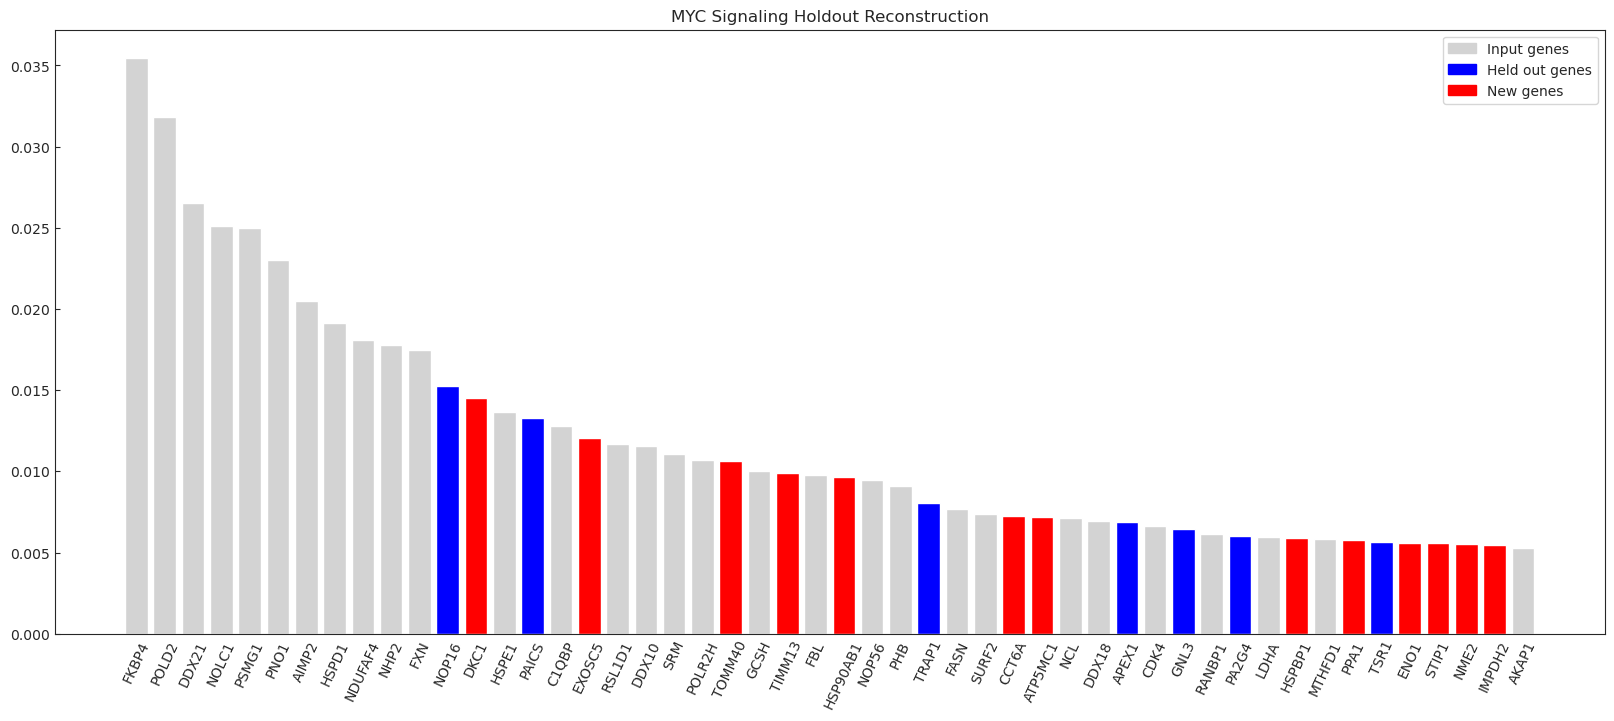

In [19]:
fig, ax = plt.subplots(figsize = (20,8))

colors = []
for i in range(len(in_train)):
    if in_train[i] == 1:
        colors.append("lightgrey")
    elif in_test[i] == 1:
        colors.append("blue")
    else:
        colors.append("red")
ax.bar(range(len(toplot)),toplot, color=colors)
ax.set_xticks(range(len(toplot)))
ax.set_xticklabels(markers[markers.best_match == "all_MYC_targets"].iloc[:,:50].values[0], rotation=65)
black_patch = mpatches.Patch(color='lightgrey', label='Input genes')
blue_patch = mpatches.Patch(color='blue', label='Held out genes')
green_patch = mpatches.Patch(color='red', label='New genes')
ax.legend(handles=[black_patch,blue_patch,green_patch])
plt.title("MYC Signaling Holdout Reconstruction")
#plt.savefig("/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/myc_holdout.svg")
plt.show()

In [20]:
markers[markers.best_match == "all_MYC_targets"]

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,best_match,jaccard,cell_type,eta,eta_high
136,FKBP4,POLD2,DDX21,NOLC1,PSMG1,PNO1,AIMP2,HSPD1,NDUFAF4,NHP2,...,GSTP1,ATP5MC2,CCDC47,SUPV3L1,NME1,all_MYC_targets,0.833333,global,0.785808,1


In [21]:
adata.obs["myc"] = out[:,136]

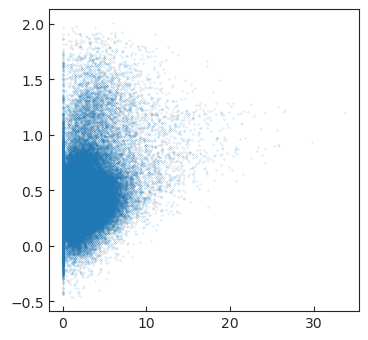

In [22]:
plt.scatter(adata.obs.myc.values, np.array(adata[:,"PPA1"].layers["imputed"]), s = 0.01)
plt.show()

In [23]:
from scipy.stats import spearmanr

In [24]:
spearmanr(adata.obs.myc.values, np.array(adata[:,"POLD2"].layers["imputed"]).ravel())

SpearmanrResult(correlation=0.3740187862350299, pvalue=0.0)

## slalom reconstruction

Load fitted slalom model on SAME train/test split

In [26]:
to_keep = ["CD8-T_tumor-reactive-like_UP",
"all_type-II-ifn-response",
"M_angiogenic-effectors",
"all_posttranslation-modification",
"all_MHC-I-presentation",
"all_G2M-transition",
"all_oxidative-phosphorylation",
"all_type-I-ifn-response",
"Mac_IL4-IL13_response",
"all_glycolysis",
"all_DNA_synthesis",
"all_G1S-transition",
"all_LYS_metabolism",
"all_MHC-II-presentation",
"all_hypoxia-response",
"all_pentose-phosphate-pathway",
"CD8-T_terminal-exhaustion",
"TNK_PD-1_signaling",
"T_tcr-activation",
"TNK_cytotoxicity-effectors","all_autophagy_regulation_positive", 
"all_MHC-I-presentation", "all_GPI-anchor_synthesis", "all_MYC_targets"]


In [27]:
# load model 
import pickle
model_path = "/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/slalom_result_gs_full.pickle"

In [28]:
with open(model_path, "rb") as f:
    slalom_model = pickle.load(f)

In [29]:
slalom_factors = slalom_model.getW()*slalom_model.getZ()

In [30]:
slalom_markers = return_markers(slalom_factors.T, id2word, n_top_vals= 200)

## Match slalom factors to input gene sets

In [31]:
temp = matching(slalom_markers,train)
slalom_markers["best_match"] = temp[0]
slalom_markers["jaccard"] = temp[1]


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


## Compute slalom validation metric

In [33]:
lst = []
for key in test.keys():
    for path in test[key].keys():
        temp_df = slalom_markers[slalom_markers.best_match == path]
        if len(temp_df) > 0:
            a = set(temp_df.iloc[0,:200].values)
            b = set(test[key][path])
            c = set(train[key][path])
            #print(path)
            #print( a& b)
            #print(b)
            #print("train: ", c)
            #print(len(a&b)/len(b))
            #print("#"*20)
            lst.append(len(a&b)/len(b ))
                

Compute validation metrics in exact same way

In [36]:
lst = {}
lst_ = {}
lst__ = {}
for key in test.keys():
    for path in test[key].keys():
        temp_df = preserved[preserved.best_match == path]
        if path in to_keep:
            if len(temp_df) > 0:
                a = set(temp_df.sort_values(by = "jaccard", ascending = False).iloc[0,:200].values)
                b = set(test[key][path])
                c = set(train[key][path])
                #print(path)
                #print( a& b)
                #print(b)
                #print("train: ", c)
                #print(len(a&b)/len(b))
                #print("#"*20)
                lst[path] = (len(a&b)/len(b ))
                lst_[path] = len(b)
                lst__[path] = len(a&b)
                

In [37]:
lst2 = {}
lst2_ = {}
for key in test.keys():
    for path in test[key].keys():
        temp_df = slalom_markers[slalom_markers.best_match == path]
        if path in to_keep:
            if len(temp_df) > 0:
                a = set(temp_df.sort_values(by = "jaccard", ascending = False).iloc[0,:200].values)
                b = set(test[key][path])
                c = set(train[key][path])
                #print(path)
                #print( a& b)
                #print(b)
                #print("train: ", c)
                #print(len(a&b)/len(b))
                #print("#"*20)
                lst2[path] = (len(a&b)/len(b ))
                lst2_[path] = len(a&b)

## Save data that gets plotted 

In [87]:
out_file = open("/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/spectra_reconstruction_values_top200.json", "w")
  
json.dump(lst, out_file, indent = 6)
  
out_file.close()

In [88]:
out_file = open("/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/slalom_reconstruction_values_top200.json", "w")
  
json.dump(lst2, out_file, indent = 6)
  
out_file.close()

In [38]:
np.mean(list(lst.values()))

0.39400450674960474

In [39]:
np.mean(list(lst2.values()))

0.13338994338994337

## Reproducible plots for reconstruction metric

In [40]:
outs1 = OrderedDict()
outs2 = OrderedDict()
for key in to_keep:
    if key in lst.keys():
        outs1[key] = lst[key]
    else:
        outs1[key] = 0.0
    if key in lst2.keys():
        outs2[key] = lst2[key]
    else:
        outs2[key] = 0.0

In [41]:
list(outs1.keys())

['CD8-T_tumor-reactive-like_UP',
 'all_type-II-ifn-response',
 'M_angiogenic-effectors',
 'all_posttranslation-modification',
 'all_MHC-I-presentation',
 'all_G2M-transition',
 'all_oxidative-phosphorylation',
 'all_type-I-ifn-response',
 'Mac_IL4-IL13_response',
 'all_glycolysis',
 'all_DNA_synthesis',
 'all_G1S-transition',
 'all_LYS_metabolism',
 'all_MHC-II-presentation',
 'all_hypoxia-response',
 'all_pentose-phosphate-pathway',
 'CD8-T_terminal-exhaustion',
 'TNK_PD-1_signaling',
 'T_tcr-activation',
 'TNK_cytotoxicity-effectors',
 'all_autophagy_regulation_positive',
 'all_GPI-anchor_synthesis',
 'all_MYC_targets']

In [42]:
outs1

OrderedDict([('CD8-T_tumor-reactive-like_UP', 0.25),
             ('all_type-II-ifn-response', 0.3333333333333333),
             ('M_angiogenic-effectors', 0.0),
             ('all_posttranslation-modification', 0.0),
             ('all_MHC-I-presentation', 0.75),
             ('all_G2M-transition', 0.1),
             ('all_oxidative-phosphorylation', 0.22077922077922077),
             ('all_type-I-ifn-response', 0.7142857142857143),
             ('Mac_IL4-IL13_response', 0.0),
             ('all_glycolysis', 0.4),
             ('all_DNA_synthesis', 0.3333333333333333),
             ('all_G1S-transition', 1.0),
             ('all_LYS_metabolism', 0.2857142857142857),
             ('all_MHC-II-presentation', 0.42857142857142855),
             ('all_hypoxia-response', 0.10256410256410256),
             ('all_pentose-phosphate-pathway', 0.5),
             ('CD8-T_terminal-exhaustion', 0.0),
             ('TNK_PD-1_signaling', 0.0),
             ('T_tcr-activation', 0.0),
             ('TN

In [43]:
outs2

OrderedDict([('CD8-T_tumor-reactive-like_UP', 0.0),
             ('all_type-II-ifn-response', 0.0),
             ('M_angiogenic-effectors', 0.0),
             ('all_posttranslation-modification', 0.0),
             ('all_MHC-I-presentation', 0.75),
             ('all_G2M-transition', 0.0),
             ('all_oxidative-phosphorylation', 0.05194805194805195),
             ('all_type-I-ifn-response', 0.42857142857142855),
             ('Mac_IL4-IL13_response', 0.0),
             ('all_glycolysis', 0.1),
             ('all_DNA_synthesis', 0.0),
             ('all_G1S-transition', 0.0),
             ('all_LYS_metabolism', 0.0),
             ('all_MHC-II-presentation', 0.2857142857142857),
             ('all_hypoxia-response', 0.05128205128205128),
             ('all_pentose-phosphate-pathway', 0.0),
             ('CD8-T_terminal-exhaustion', 0.0),
             ('TNK_PD-1_signaling', 0.0),
             ('T_tcr-activation', 0.0),
             ('TNK_cytotoxicity-effectors', 0.3333333333333333)

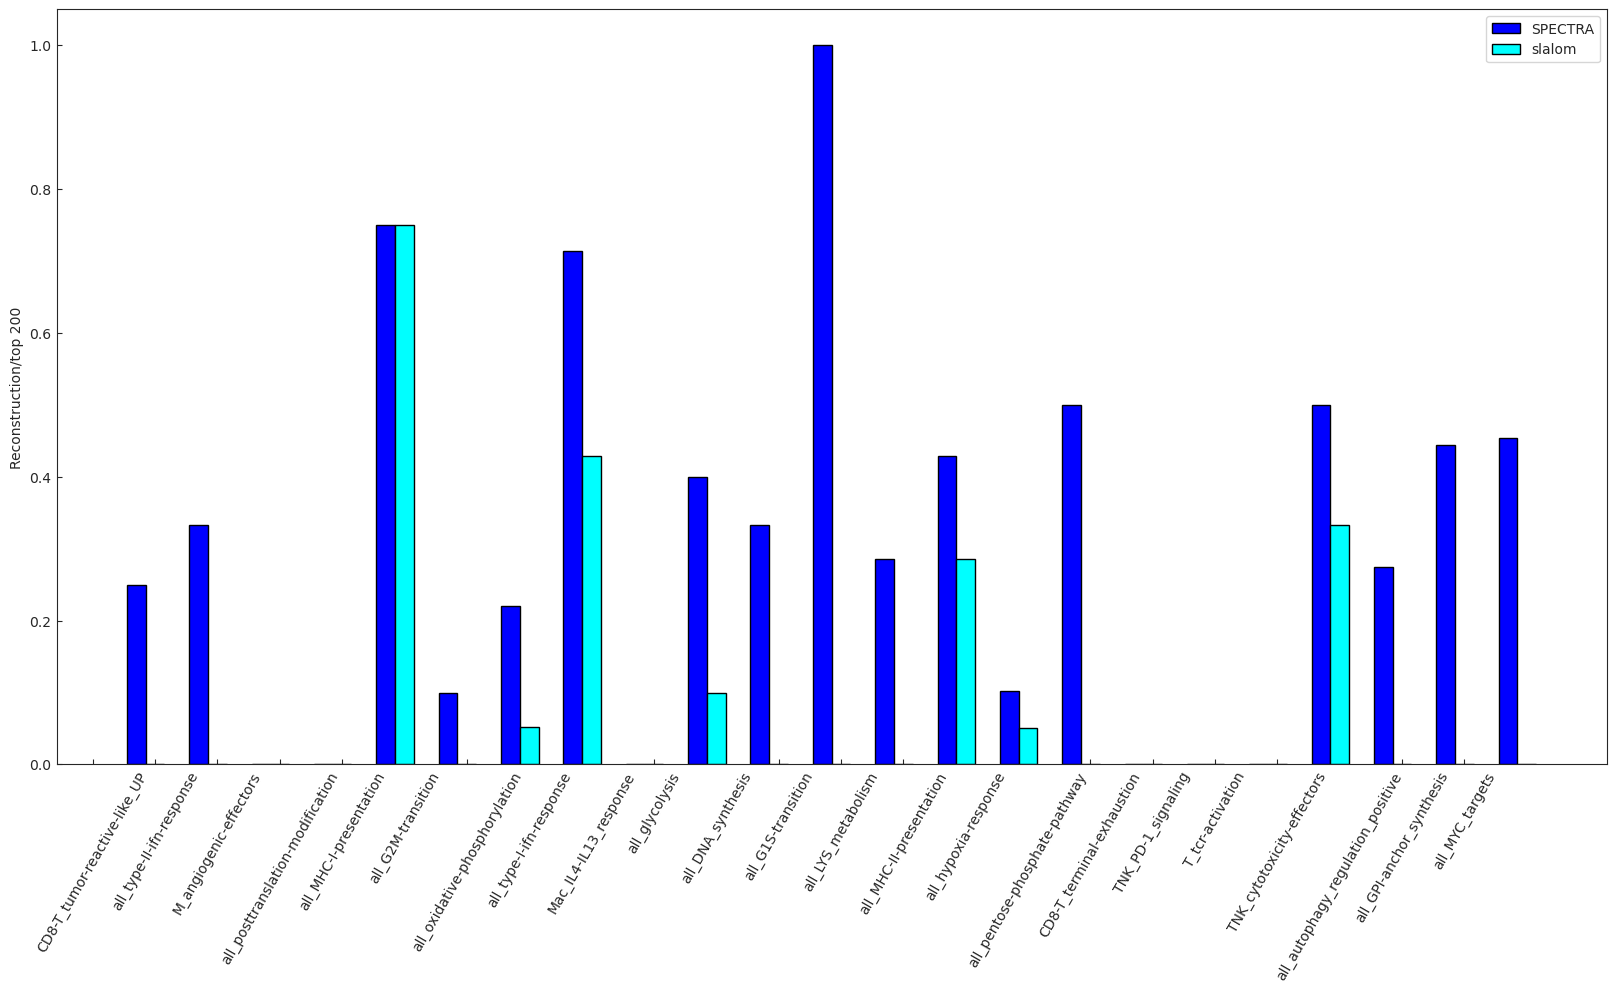

In [44]:
plt.figure(figsize = (20,10))
# width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars
bars1 = list(outs1.values())
 
# Choose the height of the cyan bars
bars2 = list(outs2.values())

 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='SPECTRA')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', capsize=7, label='slalom')
 
# general layout
plt.xticks([r + barWidth for r in [-1] + list(range(len(bars1) -1))], list(outs1.keys()), rotation = 60)
plt.ylabel('Reconstruction/top 200')
plt.legend()

 
# Show graphic
#plt.savefig("/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/reconstruction_20.svg")
plt.show()

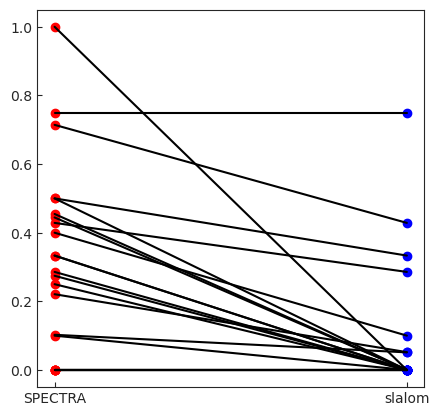

In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (5,5))
# your input data:
befores = list(outs1.values())
afters = list(outs2.values())

# plotting the points
plt.scatter(np.zeros(len(befores)), befores, label = "SPECTRA", color = "red")
plt.scatter(np.ones(len(afters)), afters, label = "slalom", color = "blue")

# plotting the lines
for i in range(len(befores)):
    plt.plot( [0,1], [befores[i], afters[i]], c='k')

plt.xticks([0,1], ['SPECTRA', 'slalom'])
plt.show()
#plt.savefig("/data/peer/kunesr/projects/SPADE_ct_scalings/SPADE_1225/baseline_models/slalom_recon/reconstruction_points.svg")